In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
#import xgboost as xgb
#import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import json
import ast
import eli5
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import time
import gc
warnings.filterwarnings('ignore')
#import shap

In [71]:
#train = pd.read_csv('dataset-0510/train.csv')
#test  = pd.read_csv('dataset-0510/test.csv')

train = pd.read_csv('FE_train.csv')
test  = pd.read_csv('FE_test.csv')

target_df = train.groupby(['city', 'town']).agg({'building_area' : ['mean', 'median'], 'land_area' : ['mean', 'median'], 'total_price' : ['mean', 'median']}).reset_index()
target_df.columns = [i[0] + '_' + i[1]  if i[1] != '' else i[0] for i in target_df.columns.tolist()]
target_df['price_land_rate_median'] = np.log1p(target_df['total_price_median']) / target_df['land_area_median']
target_df['price_building_rate_median'] = np.log1p(target_df['total_price_median']) / target_df['building_area_median']
target_df['price_land_rate_mean'] = np.log1p(target_df['total_price_mean']) / target_df['land_area_mean']
target_df['price_building_rate_mean'] = np.log1p(target_df['total_price_mean']) / target_df['building_area_mean']

combine_cols = ['city', 'town', 'price_land_rate_median', 'price_building_rate_median', 'price_land_rate_mean', 'price_building_rate_mean']
train = pd.merge(train, target_df[combine_cols], on =['city', 'town'], how='left')
test = pd.merge(test, target_df[combine_cols], on =['city', 'town'], how='left')

train.loc[train['building_area'] == 4, 'parking_area'] = train.loc[train['building_area'] == 4, 'building_area'] / train.loc[train['building_area'] == 4, 'total_floor']
test.loc[train['building_area'] == 4, 'parking_area'] = test.loc[test['building_area'] == 4, 'building_area'] / test.loc[test['building_area'] == 4, 'total_floor']
drop_cols = [i for i in train.columns if np.sum(train[i]) == 60000 and 'index' in i]

train.drop(['town'], axis = 1, inplace = True)
test.drop(['town'], axis = 1, inplace = True)
train.drop(drop_cols, axis = 1, inplace = True)
test.drop(drop_cols, axis = 1, inplace = True)
gc.collect()

618

In [75]:
len(train.columns), len(test.columns)

(419, 419)

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 59999
Columns: 419 entries, III_10 to price_building_rate_mean
dtypes: float64(192), int64(226), object(1)
memory usage: 192.3+ MB


In [9]:
def hit_score(preds, train_data):
    trues  = train_data.get_label()
    trues = np.expm1(trues)
    preds = np.expm1(preds)
    scores = ((np.absolute(preds - trues) / trues) <= 0.1)
    hit_score = np.sum(scores) / train_data.num_data()
    return 'Hit_score', hit_score, True


#categorical feature to one-hot
def one_hot(train, test, categorical_features):
    data = pd.concat([train, test], axis=0)
    for i in categorical_features:
        data = data.join(pd.get_dummies(data[i], prefix = i))
        data.drop(i, axis = 1, inplace =True)
    train = data[:60000]
    test  = data[60000:]
    return train, test

In [10]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [11]:
def Submission(Ids, preds):
    file_name = datetime.datetime.today().strftime('%m-%d-%H-%M')
    submission = pd.DataFrame({'building_id' : Ids, 'total_price' : preds})
    if not os.path.isdir('Submission'):
        os.makedirs('Submission')
    submission.to_csv('Submission/' + file_name + '.csv', index= False)

In [85]:
def lgb_model(split_num, train, test, stratified = False, if_one_hot = True):
    
    category_cols = ['building_material',
 'building_use',
 'building_type', 'city', 'parking_way']
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits = split_num, random_state=42, shuffle=True)
    train['total_price_log'] = np.log1p(train['total_price'])
    
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 10000000, 'max_depth' : 5, 'num_leaves' :30,         
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.9,     'importance_type': 'gain',
        'lambda_l1': 0.2,  'subsample': .8,   'colsample_bytree': .9, 'device' : 'gpu', 'num_trhead' : 1
    }
     
    features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
    print(len(features)) 
    
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
        
        
        clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=10000, early_stopping_rounds= 3000, categorical_feature=category_cols, feval = hit_score)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        y   = np.expm1(train['total_price_log'].iloc[val_idx]) 
        yhat = np.expm1(oof[val_idx])
        Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
        print('fold {} hit_score : {}'.format(fold_ + 1, round(Hit_score, 4) /len(train.iloc[val_idx]) * 10000))
        print('-'*30)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    print('-'*30)
    y = np.expm1(train['total_price_log']) 
    yhat = np.expm1(oof)
    Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
    print('Hit ratye : {}'.format(round(Hit_score, 4) /len(train) * 10000))
    
    display_importances(feature_importance_df)
    return predictions, oof


215
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.133255	training's Hit_score: 0.633854	valid_1's rmse: 0.200054	valid_1's Hit_score: 0.506
[20000]	training's rmse: 0.0947789	training's Hit_score: 0.776813	valid_1's rmse: 0.194024	valid_1's Hit_score: 0.536667
[30000]	training's rmse: 0.073037	training's Hit_score: 0.865417	valid_1's rmse: 0.19239	valid_1's Hit_score: 0.548
[40000]	training's rmse: 0.0593599	training's Hit_score: 0.921917	valid_1's rmse: 0.191937	valid_1's Hit_score: 0.555667
[50000]	training's rmse: 0.0499597	training's Hit_score: 0.953771	valid_1's rmse: 0.191772	valid_1's Hit_score: 0.557833
[60000]	training's rmse: 0.0431291	training's Hit_score: 0.971167	valid_1's rmse: 0.191771	valid_1's Hit_score: 0.560833
Early stopping, best iteration is:
[52344]	training's rmse: 0.0481754	training's Hit_score: 0.959125	valid_1's rmse: 0.191746	valid_1's Hit_score: 0.55875
fold 1 hit_score : 5587.5
------------------------------
Tr

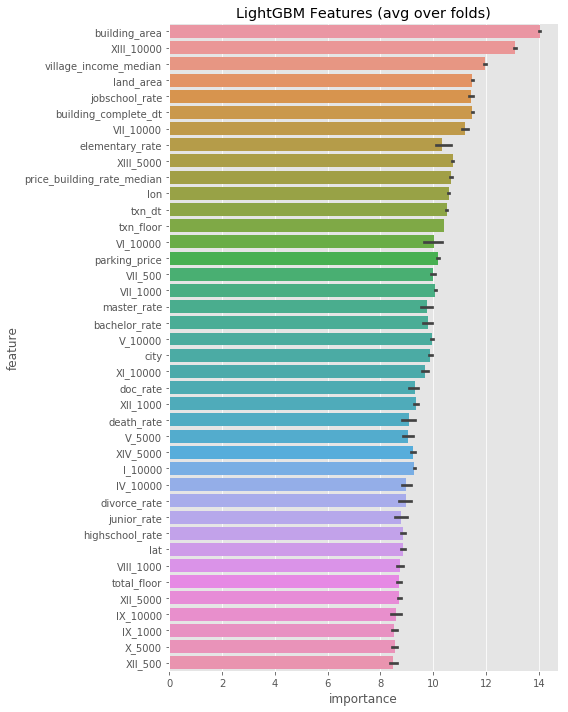

In [59]:
prediction, oof  = lgb_model(5, train, test, stratified = False)

In [66]:
train.parking_area.isna().sum()

56897

In [46]:
len(prediction)

2

215
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.136761	training's Hit_score: 0.626444	valid_1's rmse: 0.198727	valid_1's Hit_score: 0.507333
[20000]	training's rmse: 0.099557	training's Hit_score: 0.75587	valid_1's rmse: 0.191788	valid_1's Hit_score: 0.532833
[30000]	training's rmse: 0.0780212	training's Hit_score: 0.845463	valid_1's rmse: 0.189564	valid_1's Hit_score: 0.547667
[40000]	training's rmse: 0.0640624	training's Hit_score: 0.903741	valid_1's rmse: 0.188725	valid_1's Hit_score: 0.557833
[50000]	training's rmse: 0.0542085	training's Hit_score: 0.9405	valid_1's rmse: 0.188338	valid_1's Hit_score: 0.563333
[60000]	training's rmse: 0.0469798	training's Hit_score: 0.96187	valid_1's rmse: 0.188196	valid_1's Hit_score: 0.566167
[70000]	training's rmse: 0.041533	training's Hit_score: 0.974481	valid_1's rmse: 0.188132	valid_1's Hit_score: 0.567333
[80000]	training's rmse: 0.0372828	training's Hit_score: 0.982574	valid_1's rmse: 0.188109	

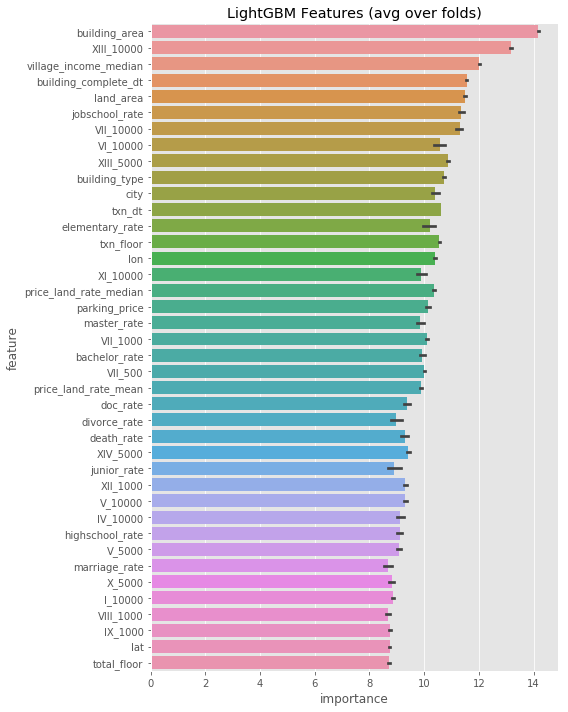

In [51]:
#7
begin = time.time()
prediction, oof = lgb_model(10, train, test, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

In [86]:
#7
begin = time.time()
prediction, oof = lgb_model(10, train, test, stratified = False)
prediction = np.expm1(prediction)
print('總共花：{} 分'.format((time.time() - begin) / 60))

417
Training until validation scores don't improve for 3000 rounds.


KeyboardInterrupt: 

In [53]:
Submission(test['building_id'], prediction)

In [55]:
gc.collect()

8984

# Record

In [ ]:
1# cv :   0.20573  hit_rate :  5054   public : 5113   note : without Fe set n_estimators = 10,000
1.1# cv : 0.20580  hit_rate :  5045   public :        note : without Fe set n_estimators = 10,000 drop village
1.2# cv : 0.20352  hit_rate :  5075   public :        note : without Fe set n_estimators = 10,000 drop village one-hot
1.3# cv : 0.20570  hit_rate :  5056   public :        note : without Fe set n_estimators = 10,000 drop with category_features

# FE and use category_features   CV : 0.20355     hit_rate : 5056  with n_estimators = 10000
# FE and use one_hot             CV : 0.20402     hit_rate : 5079  with n_estimators = 10000

# FE and use one_hot             CV : 0.20336     hit_rate : 5088  with n_estimators = 10000 fillna mean 
# FE and use category_features   CV : 0.20320     hit_rate : 5104  with n_estimators = 10000 fillna mean

# FE and use one_hot             CV : 0.20342     hit_rate : 5089  with n_estimators = 10000 fillna median 
# FE and use category_features   CV : 0.2032     hit_rate : 5097  with n_estimators = 10000 fillna median 

# FE and use one_hot             CV : 0.20342     hit_rate : 5089  with n_estimators = 10000 add min I、II...
# FE and use category_features   CV : 0.20362     hit_rate : 5152.0  with n_estimators = 10000  add min I、II...

2#    cv : 0.19764  hit_rate :         public : 5737          note : without FE set n_estimators = 1,000,000
2.1#  cv : 0.19576  hit_rate : 5634    public : 5803.8749     note : FE set n_estimators = 1,000,000 with one-hot
2.2#  cv : 0.19582  hit_rate : 5622    public : 5803.8754     note : FE set n_estimators = 1,000,000 with category_features



3# cv : 0.20471  hit_rate :  5063   public :          note :  FE set n_estimators = 10,000  without one-hot
4# cv : 0.20536  hit_rate :  5028   public :          note :  FE set n_estimators = 10,000  with one-hot    drop village
5# cv : 0.20445  hit_rate :  5081   public :          note :  FE set n_estimators = 10,000  with one-hot   
6# cv : 0.20352  hit_rate :  5075   public : 3237     note :  FE set n_estimators = 10,000  with one-hot   combine city、village and groupby encoding

7# cv : 0.19362  hit_rate :  5703   public : 5857     note :  just target-encoding and 10-fold
